## Código para testar o modelo de YOLO

---

In [7]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

In [11]:
def classify_image(image_path):    
    model = YOLO('last.pt')  
    results = model(image_path)
    
    # Display results
    for result in results:
        img_rgb = cv2.cvtColor(result.plot(show=False), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()


image 1/1 /home/louis/Documents/7/compvis/compvis-car/carro.jpeg: 640x480 3 License_Plates, 233.4ms
Speed: 4.9ms preprocess, 233.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


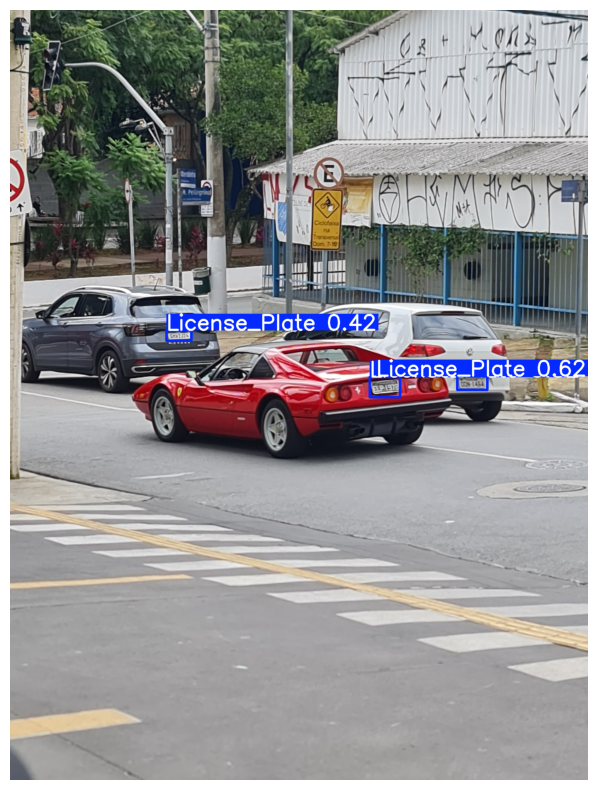

In [12]:
image_path = '/home/louis/Documents/7/compvis/compvis-car/carro.jpeg'
classify_image(image_path)


image 1/1 /home/louis/Documents/7/compvis/compvis-car/carro2.jpeg: 480x640 2 License_Plates, 262.4ms
Speed: 2.1ms preprocess, 262.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


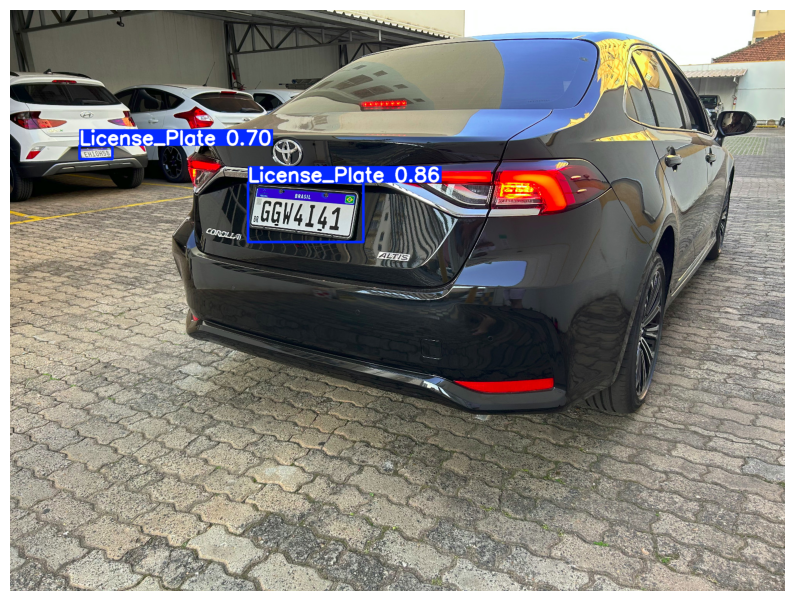

In [13]:
image_path = '/home/louis/Documents/7/compvis/compvis-car/carro2.jpeg'
classify_image(image_path)